In [51]:
import string
from collections import Counter
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import math

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')  

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)


## Funzioni di utilità

Funzioni neccessarie al trattamento dei documenti e della frasi, ossia pulizia, suddivizione in blochi e ricerca degli indici di inizio sezione.

In [52]:
def clean_phrase(phrase):
	"""clean_phrase funzione che rimuove le stopwords, segni di punteggiatura e numeri

	:param phrase: frase da pulire
	:return: frase pulita
	"""
	words = word_tokenize(phrase.lower())
	cleaned_words = [word for word in words if word.lower() not in stop_words and word not in punctuation and not word.isdigit() and word !="''"]
	return cleaned_words

def extrack_blocks(N_BLOCK, doc):
	"""
	extrack_blocks: funzione che crea i blocchi, ciascuno dei quali conterrà N_BLOCK frasi
	:N_BLOCK: tagli attesi nel documento
	:doc: documento dal quale creare i blocchi
	:return: lista contenente i blocchi appena creati
	"""
  
	blocks = []
	for i in range(0, len(doc), N_BLOCK):
		if i + (N_BLOCK-1) < len(doc):
			blocks.append(doc[i:i + N_BLOCK])
		else:
			blocks.append(doc[i:])
	return blocks

def find_section_start_indices(text):
	"""find_section_start_indices funzione che trova tutte le occorrenze di '<SECTION_SEP>' in un documento
 
	:text: testo del documento da analizzare
	:return: gli indici che indicano i tagli corretti all'interno di un documento
	"""  
	sections=text.split('<SECTION_SEP>')
	boundaries=[]
	count=1
	for sec in sections[:-1]:
		sentences=sec.split('<SENTENCE_SEP>')[:-1]
		count+=len(sentences)
		boundaries.append(count)
	return boundaries

## Funzioni di similarità
Le funzioni elencate sotto rappresentano due possibili approci per la missura della similarità tra due 'blocchi' di frasi. 
Il primo approccio lavora su token non lessicalizzati e su un approccio alla semantica di tipo statisco, la similarità tra due blocchi di frasi viene missurata dall'occorenza simultanea di un termine in entrambi i blocchi. 

Il secondo approccio è di tipo semantico distribuzionale, per ogni frase di ogni blocco calcola gli embedding e successivamente restituisce la similarità massima raggiunta dal prodotto scalare dei due blocchi.

In [53]:

def lexical_similarity_fun(block1,block2):
	"""lexical_similarity_fun funzione che calcola la cosine similarity tra due blocchi

	:block1: primo blocco di frasi da confrontare
	:block2: secondo blocco di frasi da confrontare
	:return: valore della cosine similarity tra due blocchi
	"""
	block1 = [clean_phrase(phrase) for phrase in block1]
	block2 = [clean_phrase(phrase) for phrase in block2]
	block1_merged= [word for sublist in block1 for word in sublist]
	block2_merged= [word for sublist in block2 for word in sublist]
	block1_dict = Counter(block1_merged)
	block2_dict = Counter(block2_merged)
	words = list(block1_dict.keys() | block2_dict.keys())
	numerator=0
	denominator_1=0
	denominator_2=0
	for word in words:
		numerator+=block1_dict[word]*block2_dict[word]
		denominator_1 += block1_dict[word]**2  
		denominator_2 += block2_dict[word]**2
	cos_sim=numerator / math.sqrt(denominator_1 * denominator_2)
	return cos_sim

def semantic_similarity_fun(block1, block2):
	""" semantic_similarity_fun funzione che effettua gli embedding dei due blocchi ne calcola la similarità

	:block1: primo blocco di frasi da confrontare
	:block2: secondo blocco di frasi da confrontare
	:return: valore medio del dot product tra i due blocchi (dot average)
	"""

	embeddings1 = model.encode(block1)
	embeddings2 = model.encode(block2)
	similarities = np.dot(embeddings1, np.transpose(embeddings2))
	similarity = np.max(similarities)
	
	return similarity   


## Funzione di visualizzazione


In [54]:


def plot_similiraty(graph,similarity,smoothed_similarities,actual_boundaries,predicted_boundaries,block_len,name_tag):
	"""
	plot_similiraty funzione che mostra i risultati ottenuti sotto forma di grafo
	:graph: 
	:similarity: valori di similarità ottenuto
	:smoothed_similarities: valori di similarità ottenuto smoothed
	:actual_boundaries: tagli attesi nel documento
	:predicted_boundaries: tagli calcolati tramite la lexical o semantic similarity
	:block_len: numero di frasi contenute in un blocco
	:name_tag: titolo del grafico
	:return: -
	""" 
	xpoints = np.arange(1,(len(smoothed_similarities)*block_len)+1,block_len)
	ypoints = similarity
	xpoints_smooth = np.arange(1,(len(smoothed_similarities)*block_len)+1,block_len)
	ypoints_smooth = smoothed_similarities
	graph.plot(xpoints, ypoints, '-o', color='red', label='Similarities')
	graph.plot(xpoints_smooth, ypoints_smooth, '-o', color='blue', label='Smoothed similarities')
	graph.set_title(name_tag) 

					
	for a_b in actual_boundaries:
		graph.axvline(x=(a_b-1), color='green', label='Actual boundaries')

	
	for p_d in predicted_boundaries:
		if p_d not in actual_boundaries:
			graph.axvline(x=(p_d-1), color='magenta', label='Predicted boundaries')
		else:
			graph.axvline(x=(p_d-1), color='black', label='Matched boundaries')



## Funzioni per il calcolo e la valutazione dei boundaries

In [55]:


def get_boundaries(similarities,block_len,SECTION_SENS):
	"""
	get_boundaries funzione che, dati gli score di similarità, trova i tagli secondo la formula  (y_a_{i-1} - y_a_{i}) + (y_a_{i+1} - y_a_{i})
	:similarities: vettore contenete gli score di similarità relativi ad un documento
	:block_len: numero di frasi contenute in un blocco
	:SECTION_SENS: valore che regola come un depthscore venga calcolato come boundary (mean-std/SECTION_SENS)
	:return: una lista contenente tutti i tagli effettuati su un dato documento
	"""  
	depth_score_sim=[]
	for i in range(1,len(similarities)-1):
		score=(similarities[i-1]-similarities[i])+(similarities[i+1]-similarities[i])
		depth_score_sim.append(score)
	depth_score_sim.insert(0,similarities[1]-similarities[0])
	depth_score_sim.append(similarities[-2]-similarities[-1])

	filtered=list(filter(lambda x: x > 0, depth_score_sim))
	std=np.std(filtered)
	mean=np.mean(filtered)
	threshold=(mean-(std/SECTION_SENS))

	boundaries= [i for i, v in enumerate(depth_score_sim) if v > threshold]
	boundaries = [(x*block_len)+2 for x in boundaries]
	return boundaries

def boundaries_error(actual,predicted):
	"""
	boundaries_error: funzione che calcola il numero di tagli applicati male all'interno di un documento
	:actual: tagli attesi nel documento
	:predicted: tagli calcolati tramite la cosine similarities o il dot product
	:return: il numero di tagli sbagliati in un documento
	"""
	errors=[]
	for boundary in actual:
		min_edit_distance=6000
		for pr in predicted:
			edit_distance=abs(boundary-pr)
			if(edit_distance<min_edit_distance):
				min_edit_distance=edit_distance
		errors.append(min_edit_distance)
	return sum(errors)




## Caricamento del dataset di documenti

I singoli documenti sono stati memorizzati all'interno di un file csv, ogni documento è composto da una stringa in cui il token <b>SENTENCE_SEP</b> separa una frase dall'altra e il token <b>SECTION_SEP</b> separa le sezioni del documento.

In [56]:

#contiene i documenti
df = pd.read_csv("data\\wiki_definitions.csv")  
docs=df["definitions"].astype(str).tolist()
doc_names=df["names"].astype(str).tolist()


#contiene, per ogni documento, gli indici dei separatori di paragrafo (in base alla frase)
docs_sections=[]
for doc in docs:
    sections_pos=find_section_start_indices(doc)
    docs_sections.append(sections_pos)


#contiene i documenti, ma separati frase per frase
docs_sent_by_sent=[]
for doc in docs:
    doc_t=doc.replace('<SECTION_SEP>','')
    doc_t=doc_t.replace('\r', '').replace('\n', '')
    doc_splitted=doc_t.split('<SENTENCE_SEP>')
    docs_sent_by_sent.append(doc_splitted)



## Implementazione

Escludendo l'impostazione degli iper-parametri, il codice agisce sui singoli documenti nella seguente maniera:

1. Suddivisione delle frasi del documento in blocchi di lunghezza <b>N_BLOCK</b>
2. Calcolo delle misure di similarità inter-blocco tramite i due approci precedentemente descritti
3. Smoothing delle misure di similarità 
4. Estrazzione degli indici di taglio di sezione nelle misure di similarità

Al fine di non iterare nuovamente sui documenti sono stati calcolati per ogni documento i grafici e l'errore, tali dati saranno successivamente visualizzati.

In [57]:
#Numero di frasi contenute in ogni blocco #1 0.6 3 per multi qa
N_BLOCK=1
#Valore che regola il livello di smoothing del similarity score
SMOOTH=0.7
#Valore che regola se un depthscore venga considerato come boundary o meno (mean-std/SECTION_SENS)
SECTION_SENS=2

#Genera (len(docs))*2 sotto grafici
figure, axis = plt.subplots(len(docs), 2) 
figure.set_size_inches(18.5, 8*(len(docs)))

boundaries_list=[]
boundaries_error_list=[]

for DOC_NUM in range(0,len(docs)):

    doc=docs_sent_by_sent[DOC_NUM]
    blocks = extrack_blocks(N_BLOCK, doc)

    #Calcola la similarità per ciascun blocco
    lexical_similarities=[]
    transformer_similarities=[]
    for i in range(0,len(blocks)-1):

        lex_similarity=lexical_similarity_fun(blocks[i],blocks[i+1])
        lexical_similarities.append(lex_similarity)
        bert_similarity=semantic_similarity_fun(blocks[i],blocks[i+1])
        transformer_similarities.append(bert_similarity)

    #Applica il filtro gaussiano agli score di similarità
    smoothed_lexical_similarities=gaussian_filter1d(lexical_similarities, sigma=SMOOTH)
    smoothed_transformer_similarities=gaussian_filter1d(transformer_similarities, sigma=SMOOTH)

    #Estrai i tagli e calcola l'errore per la similarità lessicale 
    boundaries_lex=get_boundaries(smoothed_lexical_similarities,N_BLOCK,SECTION_SENS)
    boundaries_error_lex=boundaries_error(docs_sections[DOC_NUM],boundaries_lex)

    #Estrai i tagli e calcola l'errore per la similarità semantica
    boundaries_emb=get_boundaries(smoothed_transformer_similarities,N_BLOCK,SECTION_SENS)
    boundaries_error_emb=boundaries_error(docs_sections[DOC_NUM],boundaries_emb)

    #Salva i risultati come tuple (lexical output, semantic output)
    boundaries_list.append((boundaries_lex,boundaries_emb))
    boundaries_error_list.append((boundaries_error_lex,boundaries_error_emb))

    #Visualizza i risultati in due grafi per ciascun approccio
    plot_similiraty(axis[DOC_NUM][0],lexical_similarities,smoothed_lexical_similarities,docs_sections[DOC_NUM],boundaries_lex,N_BLOCK,name_tag="Lexical similary for "+doc_names[DOC_NUM])
    plot_similiraty(axis[DOC_NUM][1],transformer_similarities,smoothed_transformer_similarities,docs_sections[DOC_NUM],boundaries_emb,N_BLOCK,name_tag="Semantic similary for "+doc_names[DOC_NUM])

plt.ioff()

## Calcolo e stima dell'errore 

L'errore è stato quantificato in due modi diversi:
1. Distanza dalle sezioni reali rispetto alla più prossima sezione predetta
2. Differenza tra il numero di sezioni reali e il numero di sezioni predette

In [58]:
errors = {'document': ['apple','paxton', 'paper', 'punk','computer science','emotions'], 
          'lexical_match_error': [i[0] for i in boundaries_error_list],
          'semantic_match_error':  [i[1] for i in boundaries_error_list],
          'lexical_number_of_section_error':  [abs(len(boundaries_list[i][0])-len(docs_sections[i])) for i in range(0,len(docs))] ,
          'semantic_number_of_section_error':  [abs(len(boundaries_list[i][1])-len(docs_sections[i])) for i in range(0,len(docs))] 
          }

pd_errors=pd.DataFrame(errors)
total= pd_errors.sum(numeric_only=True, axis=0)
pd_errors.loc[len(pd_errors.index)] = ['TOTAL', total['lexical_match_error'], total['semantic_match_error'],total['lexical_number_of_section_error'],total['semantic_number_of_section_error']] 

display(pd_errors)

print("Lexical (match+section) error " + str(total['lexical_match_error']+total['lexical_number_of_section_error']))
print("Semantinc (match+section) error " + str(total['semantic_match_error']+total['semantic_number_of_section_error']))


boundaries_to_pd = {'document': ['apple','paxton', 'paper', 'punk','computer science','emotions'], 'lexical_predicted_boundaries': [i[0] for i in boundaries_list],'semantic_predicted_boundaries':  [i[1] for i in boundaries_list],'real_boundaries':  docs_sections}
display(pd.DataFrame(boundaries_to_pd))

,document,lexical_match_error,semantic_match_error,lexical_number_of_section_error,semantic_number_of_section_error
0,apple,2,3,2,1
1,paxton,2,3,13,7
2,paper,2,1,2,3
3,punk,3,5,2,0
4,computer science,8,3,4,0
5,emotions,4,0,2,1
6,TOTAL,21,15,25,12


Lexical (match+section) error 46
Semantinc (match+section) error 27


,document,lexical_predicted_boundaries,semantic_predicted_boundaries,real_boundaries
0,apple,"[5, 8, 10, 15, 16]","[4, 10, 12, 16]","[4, 7, 10]"
1,paxton,"[3, 4, 6, 8, 9, 11, 14, 18, 19, 21, 26, 29, 30...","[3, 6, 8, 9, 14, 19, 21, 26, 29, 31]","[4, 23, 26]"
2,paper,"[8, 10, 14, 18, 22, 23]","[3, 5, 7, 13, 14, 18, 22]","[7, 15, 18, 22]"
3,punk,"[4, 7, 8, 11, 15, 19, 23]","[5, 11, 13, 19, 22]","[3, 8, 11, 13, 19]"
4,computer science,"[8, 12, 13, 18, 19, 21, 22, 24, 27, 28, 31]","[7, 11, 15, 19, 22, 24, 28]","[4, 7, 11, 15, 19, 24, 28]"
5,emotions,"[3, 4, 10, 12, 15, 16]","[3, 5, 7, 11, 15]","[3, 7, 11, 15]"


## Plot dei risualtati ottenuti

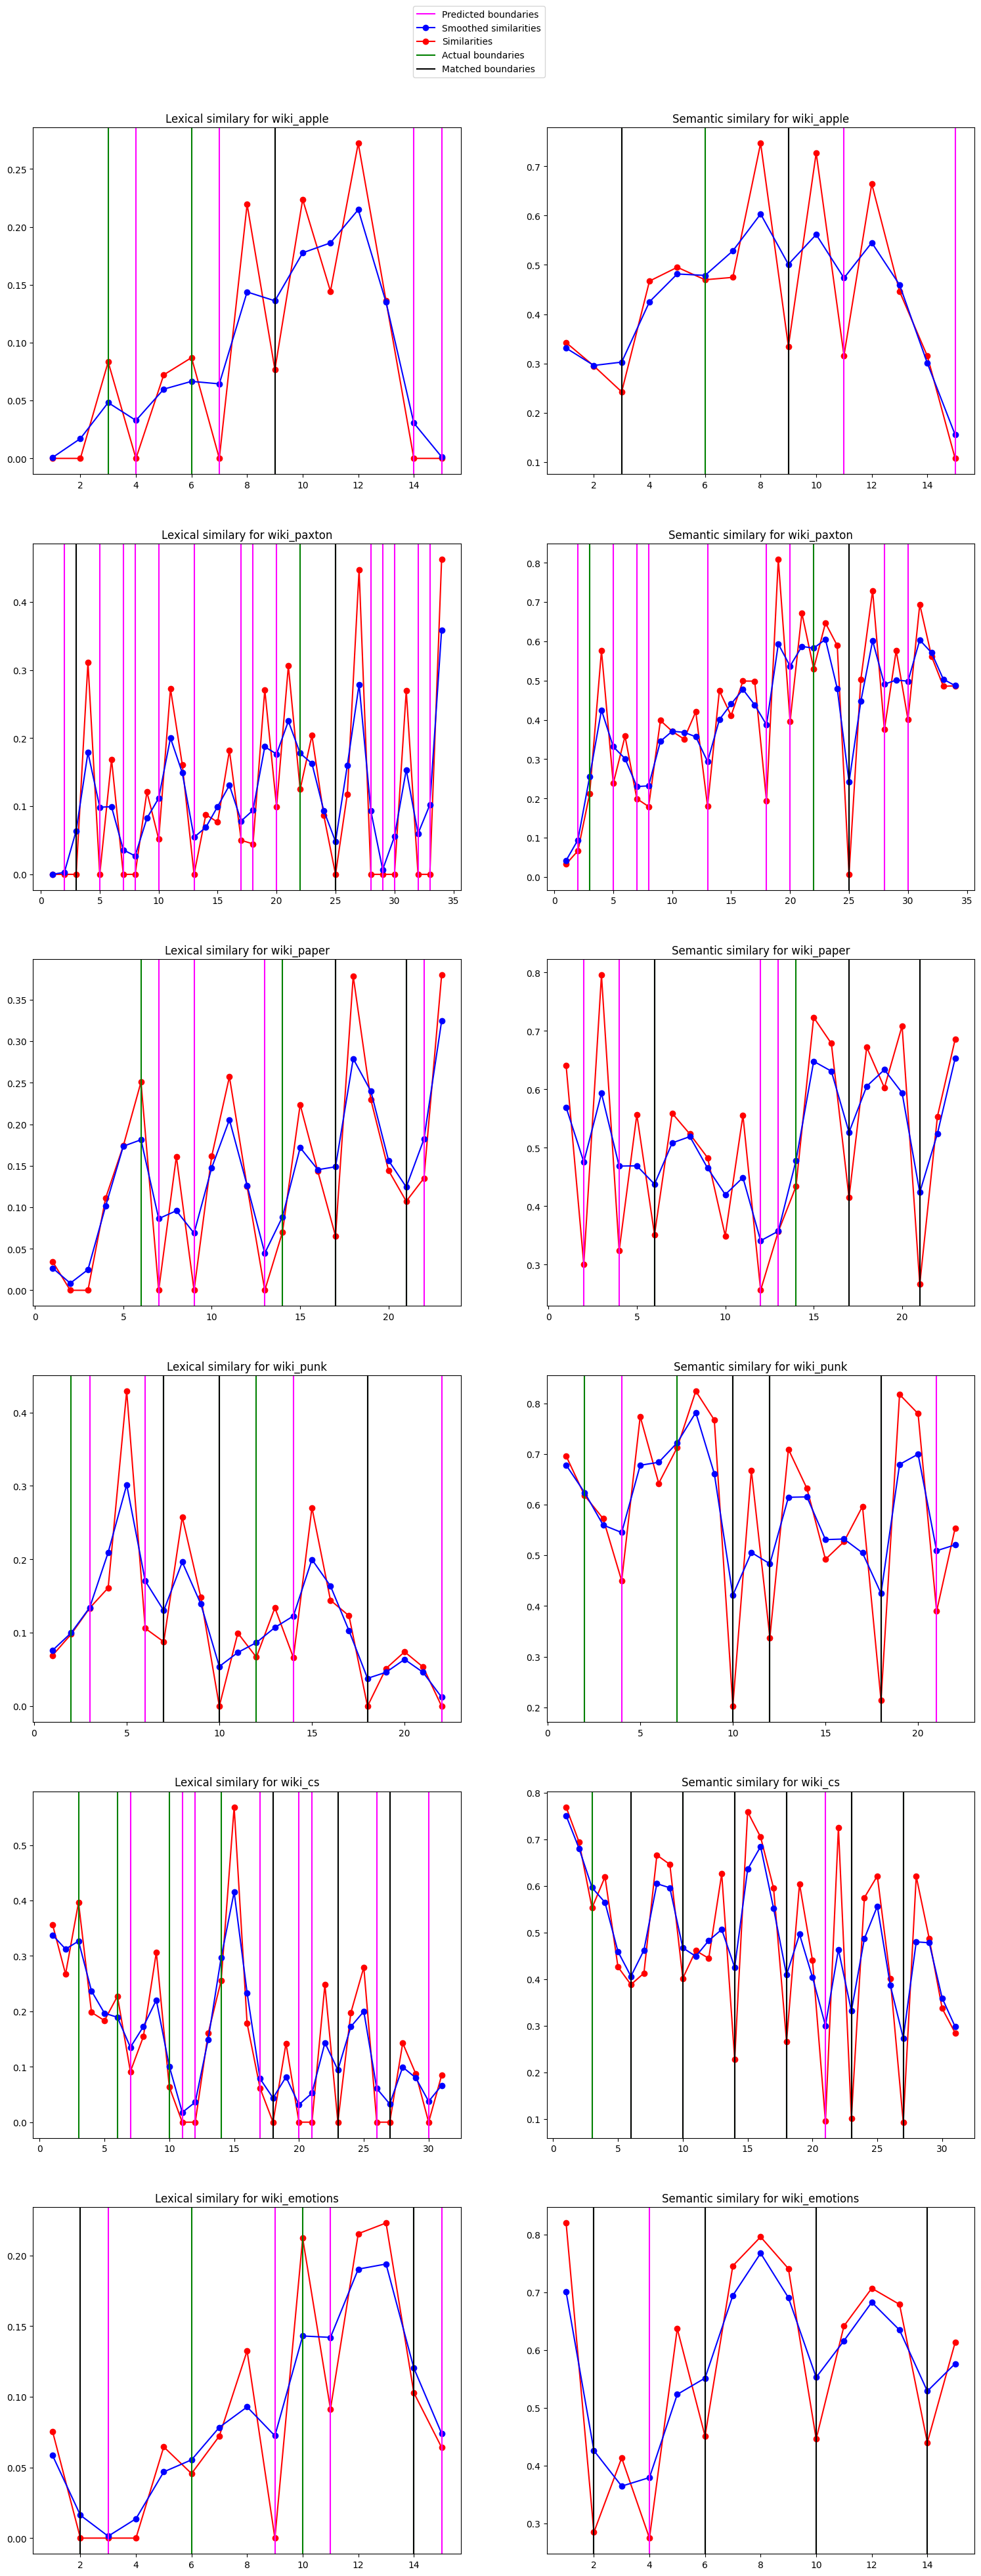

In [59]:
legend_handles, labels = axis[4][1].get_legend_handles_labels()
label_to_handle = dict(zip(labels, legend_handles))
unique_labels = set(labels)
filtered_handles = []
for label in unique_labels:
    if label in label_to_handle:
        filtered_handles.append(label_to_handle[label])
figure.legend(filtered_handles, list(unique_labels),bbox_to_anchor=(0.55,0.92))
plt.show()